<a href="https://colab.research.google.com/github/JayBlaine/WSBAI/blob/main/WSBAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regression model

Code section for reading GMEs stock data


In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import csv, math, os

def main():
    stonk = "GME"
    start = dt.datetime(2021, 1, 1)
    end = dt.datetime.today()

    data = web.DataReader(stonk,'stooq', start, end).reset_index()
    data.drop('High', 1, inplace=True)
    data.drop('Low', 1, inplace=True)

    data = data.to_csv(r'./stonkdata.csv', index=False, header=True)
    
if __name__ == '__main__':
    main()

In [2]:
# WSB data set read
# DO NOT RUN AFTER LIVE SCRAPE STARTS
# SERIOUSLY, YOU WILL RUIN DATASET ONCE LIVE SCRAPING BEGINS

def gmeChecker(title, body):
  gmeKeys = ['gme', 'gamestop', 'dfv', 'deep fucking value', 'citadel', 'ken griffin', 'keith', 'gill', 'roaring kitty', 'if he\'s in', 'if hes in']
  title = title.strip().lower()
  body = body.strip().lower()
  for key in gmeKeys:
    # body and title
    if key in title or key in body:
      return True
  return False

def dateChecker(date1):
  dtTemp = dt.datetime.strptime(date1, '%Y-%m-%d %H:%M:%S')
  actDate = dtTemp.date()
  return actDate

dateStockData = []
dateStockData = pd.read_csv('./stonkdata.csv', usecols=['Date', 'Open', 'Close'])
newD = pd.DataFrame(dateStockData)
newD = newD.iloc[::-1]
lineCount = len(dateStockData)

# date, reddit total posts, gme total posts, ratio of gme to total, 
# avg score of reddit posts, average score of gme posts, avg comments total, avg comments gme
byDate = {}

# https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts
wsbDataframe = pd.read_csv("reddit_wsb.csv")

with open('reddit_wsb.csv') as csv_file: 
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      if line_count > 1:
        tempTitle = row[0]
        tempScore = row[1]
        tempCommNum = row[4]
        tempBody = row[6]
        tempDate = row[7]
        tempPass = [tempTitle, tempScore, tempCommNum, tempBody, tempDate]
        date1 = dateChecker(tempDate)

        if date1 not in byDate.keys():
          byDate[date1] = []
          byDate[date1].append(tempPass)
        else:
          byDate[date1].append(tempPass)
      line_count+=1

redditPrelim = []

for key in byDate.keys():
  if key.year < 2021: #Gets rid of rogue row at 9/2020
      continue
  i=0
  gmeCnt = 0
  gmeCommTotal = 0
  gmeUpTotal = 0
  while i < len(byDate[key]):
    gmeCheck = gmeChecker(byDate[key][i][0], byDate[key][i][3])
    if gmeCheck:
      gmeCnt+=1
      gmeCommTotal+=int(byDate[key][i][2])
      gmeUpTotal+=int(byDate[key][i][1])
    i+=1
  if i > 0 and gmeCnt > 0: # both posts and gme posts
    redditPrelim.append([key, i, gmeCnt, gmeCnt/i, gmeUpTotal/gmeCnt, gmeCommTotal/gmeCnt])
  elif i > 0: # no gme posts
    redditPrelim.append([key, i, gmeCnt, gmeCnt/i, 0, 0])
  else: # no posts
    continue

# print(redditPrelim)
columns = dateStockData.filter(["Date"]).values
with open('wsb_clean.csv', mode='w') as write_file:
    writer = csv.writer(write_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    i=0
    date=0
    #TODO
    writer.writerow(['Date', 'open', 'close', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments'])
    while i < len(redditPrelim):
      if str(redditPrelim[i][0]) in columns:
        writer.writerow([redditPrelim[i][0], dateStockData['Open'][date], dateStockData['Close'][date], redditPrelim[i][1], 
                         redditPrelim[i][2], redditPrelim[i][3], redditPrelim[i][4], redditPrelim[i][5]])
        date+=1
      i+=1



Break

{'average_loss': 9206.849, 'label/mean': 100.26714, 'loss': 9206.849, 'prediction/mean': 176.09305, 'global_step': 30}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_gesk0re/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'predictions': array([128.11719], dtype=float32)}, {'predictions': array([113.85316], dtype=float32)}, {'predictions': array([171.08595], dtype=float32)}, {'predictions': array([146.5098], dtype=float32)}, {'predictions': array([179.08008], dtype=float32)}, {'predictions': array([217.74069], dtype=float32)}, {'predictions': array([106.51508], dtype=float32)}, {'predictions': array([124.81176], dtype=float32)}, {'predictions': array([102.52598], dtype=float32)}, {'predictions': array([209.85083], dtype=float32)}, {'predictions': array([223.35803], dtype=float32)}, {'predictions': array([231.7871], dtype=flo

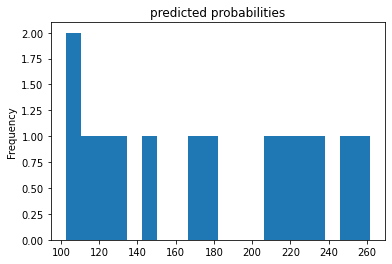

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

testDataSize = 40
fullFile = pd.read_csv("wsb_clean.csv")

# Load dataset.
dftrain = fullFile.head(testDataSize) # training data
dfeval = fullFile.iloc[testDataSize:] # testing data



dftrain.pop('Date')
dfeval.pop('Date')
# dftrain.pop('diff')
# dfeval.pop('diff')
y_train = dftrain.pop('close')
y_eval = dfeval.pop('close')
#dftrain = dftrain.astype(np.float16)
#dfeval = dfeval.astype(np.float16)

dataCol = ['open', 'total posts', 'GME count', '% GME', 'avg GME upvotes', 'avg GME comments']

feature_col = []

for feature in dataCol:
  feature_col.append(tf.feature_column.numeric_column(feature, dtype=tf.float32))

# print(feature_columns)

def make_input_fn(data, label, epochs=10, shuffle=True, batch=16):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data), label))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch).repeat(epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, epochs=1, shuffle=False)

linear_est = tf.estimator.LinearRegressor(feature_columns=feature_col)

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears consoke output
print(result)  # the result variable is simply a dict of stats about our model


pred_dicts = list(linear_est.predict(eval_input_fn))
print(pred_dicts)
print(len(pred_dicts))
probs = pd.Series([pred['predictions'][0] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [ ]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(1)

Creating Guess



In [ ]:
daysToPredict = 20
predictionLayers = 64

# Open the stock data file
stonkData = pd.read_csv('./stonkdata.csv') # format = Date, Open, Close, Volume

# Reading only the closing prices
# stonkWithDate = stonkData.filter(['Close'], ['Date'])
stonkPrices = (stonkData.filter(['Close'])).values
dataLength = len(stonkPrices)

# If we only want to train half of the data
#halfOfData = math.ceil(len(stonkPrices) * 0.5)

# Scaling the data / Takes in the stock data and makes it into a number between 0 and 1
dataScaler = MinMaxScaler(feature_range=(0,1))
scaledData = dataScaler.fit_transform(stonkPrices).reshape(-1,1)

# Spliting up the data for x and y training
x_train = []
y_train = []

# Amount we wanted trained using the length of our data
for x in range(daysToPredict, dataLength):
  x_train.append(scaledData[x - daysToPredict:x, 0])
  y_train.append(scaledData[x, 0])
  if x <= daysToPredict:
    print(f"X data-----------------\n{x_train}\nY data-----------------\n{y_train}")

x_train = np.array(x_train)
y_train = np.array(x_train)

# x_train = np.reshape(x_train, dataLength, daysToPredict, 1)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)


X data-----------------
[array([0.45200751, 0.3746745 , 0.37497729, 0.42726942, 0.46330164,
       0.48664688, 0.50641918, 0.51383758, 0.52746321, 0.52252771,
       0.53657724, 0.49672985, 0.49582147, 0.50414825, 0.312148  ,
       0.49809241, 0.53666808, 0.55416944, 0.55865076, 0.58305577])]
Y data-----------------
[0.5780899897050809]
(50, 20, 1)


Creating the training the model

In [ ]:
# Building the model
model = Sequential()
model.add(LSTM(units=predictionLayers, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# Dropout randomly inputs 0s to help against overfitting (at a rate of 0.2)
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(units=1))



In [ ]:
graphStonks = pd.read_csv("./stonkdata.csv")

graphStonks.head()
graphStonks['Close'].plot(label='GME', figsize=(16, 8), title='Adjusted Closing Price', color='red')
plt.legend();

Live Scrape code

In [ ]:
# REDDIT DATA SCRAPE
#import asyncpraw
#import nest_asyncio

#async def main():
#  reddit = asyncpraw.Reddit(client_id='ORNE1J4ncT_tGg', client_secret= 'sa-2SPPkOY-w_kMIBSeAostYFg804Q', user_agent='WSBAI:Python/urllib:v0.0.1 (by u/WSBAI_00123)', 
#                            username="WSBAI_00123", password="lint$h@d0w,./")
#  wsb_sub = await reddit.subreddit('WallStreetBets')

  
#  i = 0
#  print(reddit.read_only)
#  posts = [] # posts that are good from keywords
#  keywords = ['GME', 'gamestop', 'diamond', 'diamond hands', 'ape', 'apes']
#  postIds = {}

  # TODO: 

  # -Keyword list for relevant posts/comments
  # -handle emojis
  # -post id dictionary for posts already read through
  # -possible CV of reddit posts if jpg/png
  # -store into csv file

#  async for submission in wsb_sub.new(limit=20):
#    test = submission.downvote()
    # submission.id
    # submission.created_utc   CHECK FOR LESS THAN DAY OLD

    # submission.title
    # submission.num_comments
    # submission.upvote_ratio
    # submission.link_flair_text
    # num text keywords
    # num comment keywords


    # submission.url           POSSIBLE IMG CHECKING
    
    # submission.score   ----MAY NOT NEED----
    
    
    #---STUFF TO LOOP THROUGH TO COUNT NUM OF KEYWORDS--- comments, selftext
    #submission.selftext
    #comments = await submission.comments()
    #for comment in comments:
    #  print(comment.body)
    #  print(comment.score)

    #posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created])
  #posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])



#if __name__ == '__main__':
#  nest_asyncio.apply()
#  loop = asyncio.get_event_loop() 
#  loop.run_until_complete(main())
